In [ ]:
import torch
import time
import random
import lpips
import os
import re
import shutil
import subprocess
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from models import *
from image_utils import *
from train_utils import *
from model_utils import *

# Train

In [ ]:
# Set device
device_number = 0
DEVICE = f'cuda:{device_number}'

# Hyperparameters
LR = 0.0005
LR_DECAY_STEP = 1600
SCALE_FACTOR = 0.75
NUM_ITERS = 4000
NUM_SCALES = 5
PHI_BLOCK_COUNT = 5
PSI_BLOCK_COUNT = 4
LAMBDA_CYC = 1
LAMBDA_IDT = 1
LAMBDA_TV = 0.1
LAMBDA_PEN = 0.1
LOG_FREQ = 500
DISC_STEP = 3
GEN_STEP = 3

# Set random seed
torch.manual_seed(1641)
random.seed(1641)
np.random.seed(1641)


In [10]:
# Data Loading
def load_images(path_a=pathA, path_b=pathB):
    # Read image from given path and resize them to 250x250.
    imgA, imgB = read_domains(dir_path='data', image_A_file=pathA, image_B_file=pathB, resize=True)

    # Normalize images by mapping them to [-1, 1].
    normed_imgA = normalize_image_to_tensor(imgA).to(DEVICE)
    listA = construct_scale_pyramid(normed_imgA)

    normed_imgB = normalize_image_to_tensor(imgB).to(DEVICE)
    listB = construct_scale_pyramid(normed_imgB)

    # Higher scale image is at lower index. So, we reversed image list to align them to model list.
    listA.reverse()
    listB.reverse()
    return listA, listB

# Helper functions to visualize intermediate training results
def show_image(img_tensor):
    img = denormalize_image_from_tensor(img_tensor.detach().cpu())
    plt.imshow(img)
    plt.show()
    
def show_image_m(img1, img2):
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.show()

# To freeze network grad calculations.
def reset_grads(model,require_grad):
    for p in model.parameters():
        p.requires_grad_(require_grad)
    return model

# Start training for each scale from 0 to NUM_SCALES.
def train(listA, listB, models):
    for i in range(NUM_SCALES):
        train_scale(listA, listB, models, i)

# Train single scale.
def train_scale(listA, listB, models, model_idx):
    """
    :param listA: image pyramid for input image A.
    :param listB: image pyramid for input image B.
    :param models: model list which contains 4 model list. (A-to-B, B-to-A, disc. for A, disc. for B)
    :param model_idx: index of model of current scale. Same as scale number.
    :return: 
    """
    # Get real images for current scale.
    inpA = listA[model_idx]
    inpB = listB[model_idx]

    # Get models for current scale and change mode to train.
    gen_ab = models[0][model_idx]
    gen_ab.train()
    gen_ba = models[1][model_idx]
    gen_ba.train()

    disc_a = models[2][model_idx]
    disc_a.train()
    disc_b = models[3][model_idx]
    disc_b.train()
    
    # As, specified in paper we used Adam optimizer. For each type of model, different optimizer is created.
    # Also, we add momentum to converge better. The idea is taken from DCGAN paper.
    opt_g = torch.optim.Adam(gen_ab.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_g2 = torch.optim.Adam(gen_ba.parameters(), lr=LR, betas=(0.5, 0.999))
    
    opt_d = torch.optim.Adam(disc_a.parameters(), lr=LR, betas=(0.5, 0.999))
    opt_d2 = torch.optim.Adam(disc_b.parameters(), lr=LR, betas=(0.5, 0.999))
    
    # Learning rate schedulers defined with decay step specified in paper.
    sched_d = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_d,milestones=[LR_DECAY_STEP],gamma=0.1)
    sched_g = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_g,milestones=[LR_DECAY_STEP],gamma=0.1)
    
    sched_d2 = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_d2,milestones=[LR_DECAY_STEP],gamma=0.1)
    sched_g2 = torch.optim.lr_scheduler.MultiStepLR(optimizer=opt_g2,milestones=[LR_DECAY_STEP],gamma=0.1)
    
    
    # Training loop. One iteration added to log last iteration correctly.
    for i in range(NUM_ITERS + 1):
        # Discriminator trained in multiple step which is originated from SinGAN supplementary material.
        for j in range(DISC_STEP):
            opt_d.zero_grad()
            opt_d2.zero_grad()
            prev_ab, prev_ba, prev_aba, prev_bab, curr_ab, curr_ba = generate_input((listA, listB),
                                                                                    models, model_idx, 
                                                                                    device=DEVICE)
            
            # Real image loss of discriminator.
            out_A = - disc_a(inpA).mean()
            out_B = - disc_b(inpB).mean()

            # Fake image loss of discriminator.
            out_gB = disc_b(curr_ab).mean()
            out_gA = disc_a(curr_ba).mean()

            # Gradient penalty 
            gradient_penalty_a = gradient_penalty(disc_a, inpA, curr_ba, device=DEVICE)
            grad_a = LAMBDA_PEN * gradient_penalty_a
            
            
            gradient_penalty_b = gradient_penalty(disc_b, inpB, curr_ab, device=DEVICE)
            grad_b = LAMBDA_PEN * gradient_penalty_b
                        
            # Total of all discriminator losses
            total_loss = out_A + out_B + out_gB + out_gA + grad_a + grad_b
            total_loss.backward()
            
            opt_d.step()
            opt_d2.step()

        # Generator trained in multiple step which is originated from SinGAN supplementary material.
        for j in range(GEN_STEP):
            opt_g.zero_grad()
            opt_g2.zero_grad()
            
            # Generates generators of previos scales outputs and current generators outputs.
            prev_ab, prev_ba, prev_aba, prev_bab, curr_ab, curr_ba = generate_input((listA, listB),
                                                                                    models, model_idx, device=DEVICE)
            # Adv. Loss
            adv_loss_ba = - disc_a(curr_ba).mean()
            adv_loss_ab = - disc_b(curr_ab).mean()

            # Cycle consistency loss
            loss = nn.L1Loss()
            curr_aba = gen_ba(curr_ab, prev_aba)
            l1_aba = LAMBDA_CYC * loss(inpA, curr_aba)
    
            curr_bab = gen_ab(curr_ba, prev_bab)
            l1_bab = LAMBDA_CYC * loss(inpB, curr_bab)
            
            # Generates A-to-A and B-to-B images to calculate identity loss by using generators of previous scales.
            # image A, model BA
            curr_aa = generate_identity(listA, models[1], model_idx, device=DEVICE)
            # image B, model AB
            curr_bb = generate_identity(listB, models[0], model_idx, device=DEVICE)

            # Identity loss
            idt_aa = LAMBDA_IDT * loss(inpA, curr_aa)

            idt_bb = LAMBDA_IDT * loss(inpB, curr_bb)
            
            
            # Total variation loss
            tv_ab = LAMBDA_TV * total_variation_loss(curr_ab)
            
            tv_ba = LAMBDA_TV * total_variation_loss(curr_ba)

            # Total of all generator losses
            total_loss = adv_loss_ba + adv_loss_ab + l1_aba + l1_bab + idt_aa + idt_bb + tv_ab + tv_ba
            total_loss.backward()
            total_loss = total_loss.detach()
            
            opt_g.step()
            opt_g2.step()
        
        sched_d.step()
        sched_d2.step()

        sched_g.step()
        sched_g2.step()
        
        # Log losses at each LOG_FREQ step.
        if i % LOG_FREQ == 0:
            message = f'##########Iteration: {i}, Scale: {model_idx}##############\n' + \
                      f'Disc. real A: {out_A.item()} B: {out_B.item()}\n' + \
                      f'Disc fake A: {out_gA.item()}, B: {out_gB.item()}\n' + \
                      f'Gradient penalty A: {grad_a.item()}, B: {grad_b.item()}\n'

            message += f'Generator adv. A: {adv_loss_ba.item()}, B: {adv_loss_ab.item()}\n' + \
                      f'Cycle cons. ABA:{l1_aba.item()}, BAB: {l1_bab.item()}\n' + \
                      f'Identity AA: {idt_aa.item()}, BB: {idt_bb.item()}\n' + \
                      f'Total var. AB: {tv_ab.item()}, BA: {tv_ba.item()}'
            print(message)
            
            show_image_m(get_output_image(curr_ab), get_output_image(curr_ba))

            # Save generated images when losses printed.
            get_output_image(curr_ab).save(f'{output_path}/out_iter:{i}_sc{model_idx}_AB.jpg')
            get_output_image(curr_aba).save(f'{output_path}/out_iter:{i}_sc{model_idx}_ABA.jpg')
            get_output_image(curr_ba).save(f'{output_path}/out_iter:{i}_sc{model_idx}_BA.jpg')
            get_output_image(curr_bab).save(f'{output_path}/out_iter:{i}_sc{model_idx}_BAB.jpg')
            
    # Change mode of trained models to evaluation to reduce memory consumption and speed up inference.
    # Reset grads to freeze network
    gen_ab.eval()
    reset_grads(gen_ab,False)
    gen_ba.eval()
    reset_grads(gen_ba,False)

    disc_a.eval()
    reset_grads(disc_a,False)
    disc_b.eval()
    reset_grads(disc_b,False)
    # Empty cache to reduce memory consumption.
    torch.cuda.empty_cache()


🚀 Training TuiGAN on domain: apple2orange
##########Iteration: 0, Scale: 0##############
Disc. real A: -0.010949203744530678 B: 0.0851115956902504
Disc fake A: -0.007286932319402695, B: -0.11609292030334473
Gradient penalty A: 0.016567066311836243, B: 0.018796011805534363
Generator adv. A: 0.015391077846288681, B: 0.12769171595573425
Cycle cons. ABA:0.34020838141441345, BAB: 0.536891758441925
Identity AA: 0.3220286965370178, BB: 0.5300565958023071
Total var. AB: 0.0021010993514209986, BA: 0.0017756018787622452


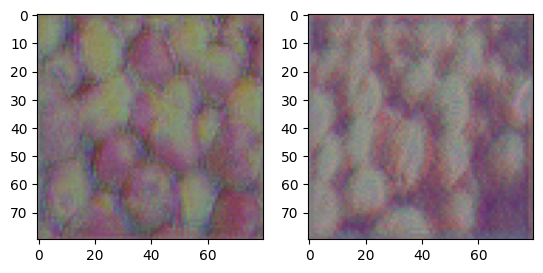

##########Iteration: 500, Scale: 0##############
Disc. real A: 0.3142746686935425 B: 0.9275391697883606
Disc fake A: -0.6477517485618591, B: -1.2187750339508057
Gradient penalty A: 0.14816385507583618, B: 0.12050582468509674
Generator adv. A: 0.6279712319374084, B: 1.2366013526916504
Cycle cons. ABA:0.11319661885499954, BAB: 0.07656458765268326
Identity AA: 0.029971860349178314, BB: 0.02455253340303898
Total var. AB: 0.004986077547073364, BA: 0.006710428278893232


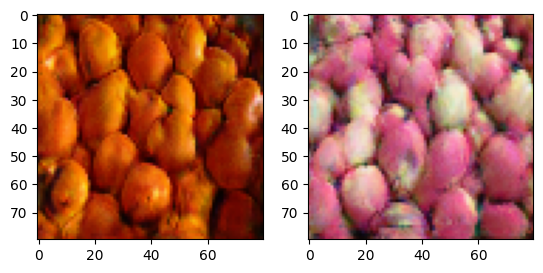

##########Iteration: 1000, Scale: 0##############
Disc. real A: 0.1585594117641449 B: 1.0779484510421753
Disc fake A: -0.491412878036499, B: -1.356477975845337
Gradient penalty A: 0.0742761418223381, B: 0.1148354783654213
Generator adv. A: 0.4912346303462982, B: 1.3652212619781494
Cycle cons. ABA:0.09744301438331604, BAB: 0.0716104805469513
Identity AA: 0.026782462373375893, BB: 0.020591173321008682
Total var. AB: 0.004223119001835585, BA: 0.0063969143666327


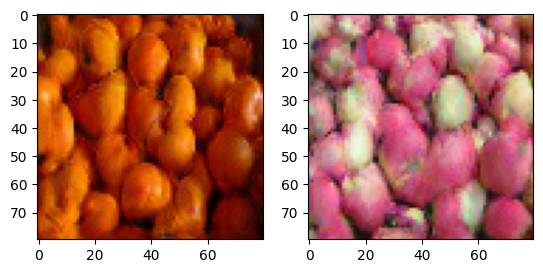

##########Iteration: 1500, Scale: 0##############
Disc. real A: 0.5225435495376587 B: 1.4626301527023315
Disc fake A: -0.8489871025085449, B: -1.704293131828308
Gradient penalty A: 0.08698158711194992, B: 0.04616294056177139
Generator adv. A: 0.872107207775116, B: 1.673103928565979
Cycle cons. ABA:0.09669526666402817, BAB: 0.06881172209978104
Identity AA: 0.02514098584651947, BB: 0.018146226182579994
Total var. AB: 0.004083860665559769, BA: 0.006875473540276289


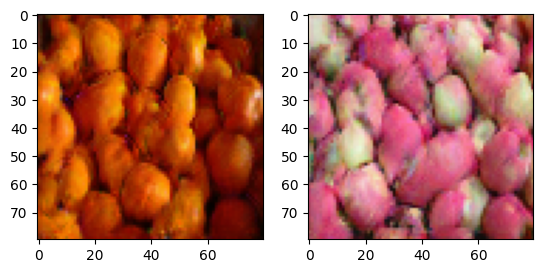

##########Iteration: 2000, Scale: 0##############
Disc. real A: 0.2983696162700653 B: 1.5917805433273315
Disc fake A: -0.6473040580749512, B: -1.8419631719589233
Gradient penalty A: 0.11912725120782852, B: 0.13636501133441925
Generator adv. A: 0.6541966199874878, B: 1.840809941291809
Cycle cons. ABA:0.08645965158939362, BAB: 0.06428977102041245
Identity AA: 0.02203742042183876, BB: 0.016823062673211098
Total var. AB: 0.004283008631318808, BA: 0.007194367237389088


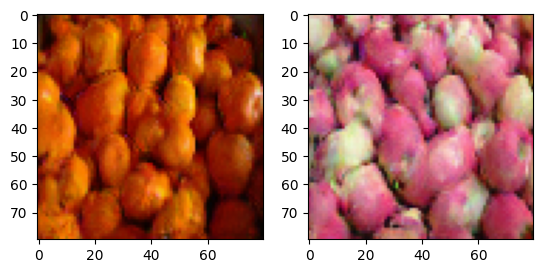

In [ ]:
domains = [
    "apple2orange",
    "horse2zebra",
    "milk2bubblemilk",
    "vanilla2chocolate"
]

results = []

for data_name in domains:
    print(f"\n🚀 Training TuiGAN on domain: {data_name}")

    pathA = f'{data_name}_A.jpg'
    pathB = f'{data_name}_B.jpg'
    output_path = f'results/{data_name}'
    Path(output_path).mkdir(parents=True, exist_ok=True)

    # Load and prepare data
    imgA, imgB = read_domains(dir_path='data', image_A_file=pathA, image_B_file=pathB, resize=True)
    listA = construct_scale_pyramid(normalize_image_to_tensor(imgA).to(DEVICE)); listA.reverse()
    listB = construct_scale_pyramid(normalize_image_to_tensor(imgB).to(DEVICE)); listB.reverse()

    # Initialize models
    listg_ab, listg_ba, listd_a, listd_b = create_models(num_scale=NUM_SCALES, device=DEVICE)

    # Start timing
    start_time = time.time()

    # Train
    train(listA, listB, (listg_ab, listg_ba, listd_a, listd_b))

    # End timing
    end_time = time.time()
    elapsed = end_time - start_time
    avg_iter_time = elapsed / (NUM_ITERS * NUM_SCALES)

    print(f"⏱️ Total training time for {data_name}: {elapsed:.2f} seconds")
    print(f"🧮 Average time per iteration: {avg_iter_time:.4f} seconds")

    # Save result row
    results.append({
        "Domain": data_name,
        "Total Time (s)": round(elapsed, 2),
        "Time per Iteration (s)": round(avg_iter_time, 4)
    })

    # Save models
    save_models(listg_ab, listg_ba, listd_a, listd_b, data_name)

    # Generate and save final output
    curr_ab, curr_ba = generate_outputs((listA, listB), (listg_ab, listg_ba, listd_a, listd_b), NUM_SCALES - 1)
    curr_ab.save(f"{output_path}/{data_name}_translated_ab.jpg")
    curr_ba.save(f"{output_path}/{data_name}_translated_ba.jpg")

    print(f"✅ Generated images saved to {output_path}")

# Save all results
df = pd.DataFrame(results)
df.to_csv("tuigan_time_results.csv", index=False)
print("\n📁 Saved training time results to tuigan_eval_results.csv")

# Evaluation

In [ ]:
lpips_model = lpips.LPIPS(net='vgg').eval().to(device)
vgg_model = models.vgg19(pretrained=True).features[:8].eval().to(device)
loss_fn = torch.nn.MSELoss()

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((288, 288)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def calculate_fid(real_image, generated_image):
    real_dir = "./fid_temp/real"
    gen_dir = "./fid_temp/generated"
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(gen_dir, exist_ok=True)
    for f in os.listdir(real_dir): os.remove(os.path.join(real_dir, f))
    for f in os.listdir(gen_dir): os.remove(os.path.join(gen_dir, f))
    shutil.copy(real_image, os.path.join(real_dir, "real.png"))
    shutil.copy(generated_image, os.path.join(gen_dir, "gen.png"))
    result = subprocess.run(f"python -m pytorch_fid {real_dir} {gen_dir}", shell=True, capture_output=True, text=True)
    output = result.stdout.strip()
    match = re.search(r'FID:\s*([\d.]+)', output)
    return float(match.group(1)) if match else None

def calculate_lpips(real_image, generated_image):
    img1 = load_image(real_image)
    img2 = load_image(generated_image)
    with torch.no_grad():
        return lpips_model(img1, img2).item()

def calculate_vgg_loss(real_image, generated_image):
    img1 = load_image(real_image)
    img2 = load_image(generated_image)
    with torch.no_grad():
        f1 = vgg_model(img1)
        f2 = vgg_model(img2)
        return loss_fn(f1, f2).item()

In [ ]:
datasets = [
    ('horse2zebra', './data/horse2zebra_B.jpg', './results/horse2zebra/horse2zebra_translated_ab.jpg'),
    ('apple2orange', './data/apple2orange_B.jpg', './results/apple2orange/apple2orange_translated_ab.jpg'),
    ('milk2bubblemilk', './data/milk2bubblemilk_B.jpg', './results/milk2bubblemilk/milk2bubblemilk_translated_ab.jpg'),
    ('vanilla2chocolate', './data/vanilla2chocolate_B.jpg', './results/vanilla2chocolate/vanilla2chocolate_translated_ab.jpg')
]

results = []
for project_name, real_image, generated_image in datasets:
    print(f"\n📌 Evaluating {project_name} dataset...")

    print("🔹 Calculating FID...")
    fid_score = calculate_fid(real_image, generated_image)

    print("🔹 Calculating LPIPS...")
    lpips_score = calculate_lpips(real_image, generated_image)

    print("🔹 Calculating VGG Perceptual Loss...")
    vgg_loss_score = calculate_vgg_loss(real_image, generated_image)

    results.append((project_name, fid_score, lpips_score, vgg_loss_score))

# Display Results
print("\n📌 Evaluation Results:")
print(f"{'Project':<30} {'FID ↓':<10} {'LPIPS ↓':<10} {'VGG Loss ↓':<10}")
for project_name, fid_score, lpips_score, vgg_loss_score in results:
    fid_display = f"{fid_score:.2f}" if fid_score is not None else "N/A"
    print(f"{project_name:<30} {fid_display:<10} {lpips_score:<10.4f} {vgg_loss_score:<10.4f}")

# Averages
valid_fid_scores = [fid for _, fid, _, _ in results if fid is not None]
avg_fid = sum(valid_fid_scores) / len(valid_fid_scores) if valid_fid_scores else None
avg_lpips = sum([lp for _, _, lp, _ in results]) / len(results)
avg_vgg = sum([vgg for _, _, _, vgg in results]) / len(results)

print("\n📊 Average Scores:")
if avg_fid is not None:
    print(f"FID ↓: {avg_fid:.2f}")
print(f"LPIPS ↓: {avg_lpips:.4f}")
print(f"VGG Loss ↓: {avg_vgg:.4f}")

# Save evaluation results to CSV
df = pd.DataFrame([
    {
        "Domain": project_name,
        "FID ↓": round(fid_score, 2) if fid_score is not None else "N/A",
        "LPIPS ↓": round(lpips_score, 4),
        "VGG Loss ↓": round(vgg_loss_score, 4)
    }
    for project_name, fid_score, lpips_score, vgg_loss_score in results
])

# Add average row
avg_row = {
    "Domain": "Average",
    "FID ↓": round(avg_fid, 2) if avg_fid is not None else "N/A",
    "LPIPS ↓": round(avg_lpips, 4),
    "VGG Loss ↓": round(avg_vgg, 4)
}
df.loc[len(df)] = avg_row

# Save to file
csv_path = "tuigan_eval_results.csv"
df.to_csv(csv_path, index=False)

print(f"\n📁 Evaluation results saved to: {csv_path}")